In [ ]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Kernel methods

Kernel methods are machine learning methods where the data need not be transformed by a feature mapping but instead a similarity function $$K(x,y)$$ between samples $x$ and $x'$, determines the feature encoding, and satisfies

$$K( {x} ,{x'} )=\langle \varphi ( {x} ),\varphi ( {x'} )\rangle _{\mathcal {V}},$$
where  $${\displaystyle \varphi \colon {\mathcal {X}}\to {\mathcal {V}}}$$
is the feature mapping. Note that the above implies that the kernel matrix $K_{ij} = K(x_i,x_j)$ must be positive semidefinite.  Typically $\dim \mathcal{V} > \dim \mathcal{X}$.

 The best example of a kernel method is the SVM problem [expand].

 A drawback is the computation of the kernel matrix of pairs of points. Note that the solution to a kernel problem scales as $O(n)$ where $n$ is number of training samples [Williams-Seeger](https://papers.nips.cc/paper/2000/file/19de10adbaa1b2ee13f77f679fa1483a-Paper.pdf).

 ## Approximations

Two main approximations to the Kernel computation:
 - random Fourier features,
 - and Nystrom method.

 [Nystrom vs RFF](https://papers.nips.cc/paper/2012/file/621bf66ddb7c962aa0d22ac97d69b793-Paper.pdf) attempts to differentiate between these methods:
 - A key difference  is that the Nystrom method uses a data-dependent basis while random Fourier features uses data independent basis (sampled from a normal dist).
 - The above leads to an improved performance for Nystrom approximations to kernel learning.

## Nystrom approximation outline

Let $K(x,y)$ be the kernel (Green's function) for some operator, and let $\{\phi_i(x), \lambda_i\}_{i=1}^N$ be eigenpairs so that

$$ K(x,y) = \sum_{i=1}^N \lambda_i \phi_i(x)\phi_i(y),$$
where $N\leq \infty$ and $0 \geq \lambda_1 \geq \lambda_2 \geq \cdots$ .

We assume that the eigenvfunctions are orthogonal with respect to the measure $p$, the probability density of $x$. This gives
$$\int K(x,y)\phi_i(y)p(y)dy = \lambda_i\phi_i(x). $$

The above integral is approximated by empirical average:

$$\frac{1}{q}\sum_{k=1}^q K(x,x_k)\phi_i(x_k) \approx \lambda_i\phi_i(x), \tag{4}$$

where the $\{x_1, \dots , x_q \}$ iid samples are drawn using $p(x)$ (or even simpler using a uniform distribution). Under this approximation we obtain the empirical constraint:

$$ \frac{1}{q} \sum_{k=1}^q \phi_i(x_k)\phi_j(x_k) \approx \delta_{ij}.$$

Equation (4) can be written as the matrix eigenvalue problem
$$K^{(q)}U^{(q)} = U^{(q)} \Lambda^{(q)},$$
where $K^{(q)}_{ij} = K(x_i,x_j)$ with $i,j = 1,\dots,q$; $U^{(q)} \in \mathbb{R}^{q\times q}$ is column orthonormal; and $\Lambda^{(q)} = \operatorname{diag}(\lambda_1^{(q)}, \dots \lambda_q^{(q)})$ with $\lambda_1^{(q)} \geq \dots \lambda_q^{(q)} \geq 0$. This correspondence holds if we take

$$ \phi_i(x_j) \approx \sqrt(q) U^{(q)}_{ji} \ \ \ , \ \ \ \lambda_i \approx \frac{\lambda^{(q)}_i}{q}.$$

Inserting into the integral equation we obtain the Nystrom approximation for the $i$th eigenfunction

$$ \phi_i(y) \approx \frac{\sqrt{q}}{\lambda_i^{(q)}}\sum_{k=1}^q K(y,x_k)U^{(q)}_{ki} = \frac{\sqrt{q}}{\lambda_i^{(q)}} k_y \cdot u_i^{(q)},$$

where $k_y := (K(x_1,y), \dots K(x_q,y))^T$, and $u_i^{(q)} := U^{(q)}[:,i]$.



# Linear algebra steps and pseudocode

## Pseudocode

Following [Drineas-Mahoney](https://www.stat.berkeley.edu/~mmahoney/pubs/kernel_JMLR.pdf) and [wiki](https://en.wikipedia.org/wiki/Singular_value_decomposition) .

-----
**Pseudocode**

Input: $X \in \mathbb{R}^{n\times D}$ , data matrix ($n$ samples, $D$ attributes)

1. Pick $q$ row vectors from $X$ in i.i.d. trials with uniform probability.

2. Build $X_q \in \mathbb{R}^{q\times D}$ from the selected rows.
3. Build smaller kernel $K_q := X_qX_q^T.$
4. Apply SVD on $K_q$: $K_q = U_q\Sigma_qU_q^T$.
5. Compute $K_{n,q} :=XX^T_q \ , \ K_q^{-1} = U_q\Sigma^{-1}_qU_q^T$.
6. Compute $\tilde K := K_{n,q} K_q^{-1} K_{n,q}^T$.

Return $\tilde K$

------



### Tiny example

In [ ]:
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt

In [ ]:
n = 50; D = 25; 
X = np.random.rand(n,D)

In [ ]:
def K_nystrom(X:np.array, q:int):
  ''' Function to produce Nystrom approximation to Kernel
      associated XX^T with a dataset X.
      
      Args: X : dataset, 2d array
            q : integer between 1 and len(X). This value is
                how many samples from X to use.
      Return: Nystrom approximation to XX^T'''
      
    # sample data
    n = X.shape[0]
    idx = np.random.randint(n, size=(q,1)).squeeze()
    X_q = X[idx]
    # small kernel
    K_q = X_q @ X_q.T
    # decompose
    U, s, Vh = svd(K_q)
    # build mappings
    K_nq = X @ X_q.T
    K_q_inv =  U @ np.linalg.inv(np.diag(s)) @ U.T

    K_approx = K_nq @ K_q_inv @ K_nq.T
    return K_approx

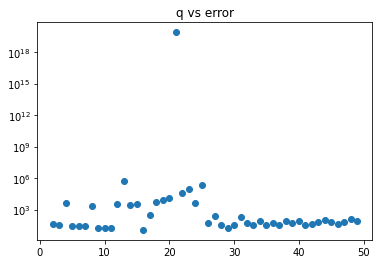

In [ ]:
K = X @ X.T
diff_norm = []
for q in range(2, X.shape[0]):
    diff_norm.append(np.linalg.norm(K - K_nystrom(X,q)))
plt.scatter(range(2,X.shape[0]), diff_norm)
plt.yscale('log')
plt.title('q vs error')
plt.show()
